In [1]:
import sqlite3
import pandas as pd
import numpy as np
import time
from utils import *
from ReactNode import ReactNode
from ChemNode import ChemNode
from MCTS import MCTS
from PNS import PNS
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('buyable.db')
buyable = conn.cursor()
analyzer = Retrosim()
retrobiocat = pd.read_pickle("data/retrobiocat_database.pkl")

In [14]:
smile = "c1ccc(C2CCCCN2)cc1"
root = ChemNode(smile, 0, None, True, buyable, retrobiocat, analyzer, None)

In [15]:
pns = PNS(root, 4)
start = time.time()
pns.proof_number_search(root)
end = time.time()
print(pns.count)
print(f'Root score: {root.solution}')
print(f'Time taken: {end-start}')

313
Root score: True
Time taken: 35.688640117645264


In [16]:
def prune_tree(node: ChemNode):
    """
    Prune the tree by removing all non-solution pathways.

    :param node: The root ChemNode to prune.
    :return: None (modifies the tree in-place).
    """
    # Iterate over a copy of the reactions to safely modify the original list
    for reaction in node.reactions[:]:
        # Check if all reagents in the reaction are solutions
        if all(reagent.solution for reagent in reaction.reagents):
            # Recursively prune each reagent
            for reagent in reaction.reagents:
                prune_tree(reagent)
        else:
            # Remove non-solution reagents from the reaction
            for reagent in reaction.reagents[:]:
                if not reagent.solution:
                    reaction.reagents.remove(reagent)
            
            # If the reaction has no reagents left, remove the reaction
            if not reaction.reagents:
                node.reactions.remove(reaction)

    # If the node itself is not a solution and has no reactions, prune it at the parent level
    if not node.solution and not node.reactions:
        return False


In [43]:
def prune_tree(node: ChemNode) -> bool:
    """
    Prune the tree by removing all non-solution pathways.

    :param node: The root ChemNode to prune.
    :return: A boolean indicating whether the node (and its subtree) is part of a valid solution path.
    """
    # If the node is a solution, keep it
    if node.solution:
        return True

    # Prune reactions in-place
    i = 0
    while i < len(node.reactions):
        reaction = node.reactions[i]
        
        # Prune the reagents of this reaction
        reaction.reagents = [reagent for reagent in reaction.reagents if reagent.solution]
        
        # If the reaction has no valid reagents, remove it
        if not reaction.reagents:
            node.reactions.pop(i)
        else:
            i += 1

        for reagent in reaction.reagents:
            prune_tree(reagent)

    # If the node has no valid reactions and is not a solution, it is removed
    return bool(node.reactions)

In [20]:
def prune_tree(node:ChemNode):
    # Base case: if the node is a leaf
    if not node.solution:
        node.parent_reaction.reagents.remove(node)
        # also remove reaction as one invalid reagent will make the reaction invalid
        if node.parent_reaction.parent_chemical is not None:
            node.parent_reaction.parent_chemical.reactions.remove(node.parent_reaction)

    for reaction in node.reactions:
        for reagent in reaction.reagents:
            prune_tree(reagent)

# Prune the tree starting from the root
prune_tree(root)

In [17]:
# Prune the tree starting from the root
prune_tree(root)

In [18]:
for react in root.reactions:
    #if all(reagent.solution for reagent in react.reagents):
    reagent_smiles = [f'{reagent.smile}: {reagent.solution}' for reagent in react.reagents]
    print(f'{react.reaction_name}: {reagent_smiles}')

Imine reduction: ['c1ccc(C2=NCCCC2)cc1: True']
Imine reduction: ['C1=NC(c2ccccc2)CCC1: True']


In [8]:
# Plan: Go down tree, copying along a given path to add to a single path list

def generate_subtrees(node: ChemNode):
    # Base case: if the node is a leaf
    if node.solution and not node.reactions: # Leaf node
        node.solution = False
        return node.copy()
    
    copy = node.copy()
    # If the node is not a leaf, generate subtrees for all reactions
       
    reaction = node.reactions[0]
    react = reaction.copy()
    for reagent in reaction.reagents:
        if reagent.solution:
            react.add_reagent(generate_subtrees(reagent))

    if all(not reagent.solution for reagent in node.reactions[0].reagents):
        node.reactions.pop(0)

    if not node.reactions:
        node.solution = False

    

    copy.reactions.append(react)
    return copy

def generate_paths(root: ChemNode):
    paths = []
    while root.solution:
        paths.append(generate_subtrees(root))
    return paths

In [19]:
paths = generate_paths(root)

In [20]:
print(len(paths))

46


In [11]:
def path_explorer(root: ChemNode):
    """
    Prints the path given a subtree
    """

    stack = []
    stack.append(root)
    count = 0
    while stack:
        print(f"BRANCH {count}:\n-----------------")
        count += 1
        root = stack.pop()
        print(f'Chem: {root.smile}')
        while root.reactions:
            print(f'Reaction: {root.reactions[0].reaction_name}')
            if len(root.reactions[0].reagents) > 1:
                print(f"SPLIT: Chem1: {root.reactions[0].reagents[0].smile}, Chem2: {root.reactions[0].reagents[1].smile}\n")
                stack.append(root.reactions[0].reagents[1])
            else:
                print(f'Chem: {root.reactions[0].reagents[0].smile}')
            root = root.reactions[0].reagents[0]
        print("BUYABLE\n")
        

In [21]:
path_explorer(paths[2])

BRANCH 0:
-----------------
Chem: c1ccc(C2CCCCN2)cc1
Reaction: Imine reduction
Chem: c1ccc(C2=NCCCC2)cc1
Reaction: Intramolecular imine formation
Chem: NCCCCC(=O)c1ccccc1
Reaction: Aldehyde amination
Chem: O=CCCCC(=O)c1ccccc1
Reaction: Ene reduction


IndexError: list index out of range

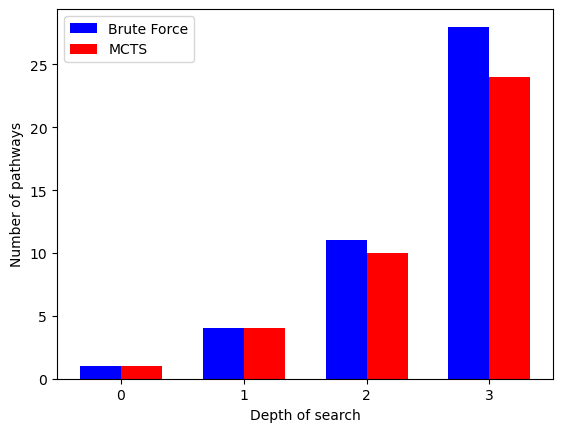

In [38]:
pnsNum = [1, 4, 11, 28]
mctsNum = [1, 4, 10, 24]
indices = np.arange(len(pnsNum))

width = np.min(np.diff(indices))/3

fig = plt.figure()
ax = fig.add_subplot(111)
# matplotlib 3.0 you have to use align
ax.bar(indices-width,pnsNum,width,color='b', label='Brute Force',align='edge')
ax.bar(indices,mctsNum,width,color='r', label='MCTS', align='edge')


# bar graph the number of pathways at each level no x-axis labels
ax.set_xticks(indices)
ax.set_xlabel('Depth of search')
ax.set_ylabel('Number of pathways')
ax.legend()
plt.show()
